# H2Know Modeling - Baseline Models

Notebook Contents:
- Baseline model
- Reasoning behind choosing XGBoost model
- Baseline XGBoost model

## II. NB Setup

In [ ]:
# Install modules
%%capture
!pip install category-encoders

In [ ]:
# Import modules

# General
# from google.colab import files
# from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import timeit
import datetime as dt
import io

# ML
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss, matthews_corrcoef, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import category_encoders as ce
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

In [ ]:
# Set up Google Drive
# drive.mount("/content/gdrive")

# Run below if above command giving some trouble
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Read in Data
# FILE_PATH = '/content/gdrive/My Drive/Capstone/Capstone_Sum23/03_Data/'#'/content/gdrive/My Drive/Capstone_Sum23/03_Data/'

df_raw = pd.read_csv('data/clean_final_full_dataset_v2.csv', low_memory=False)

## III. Quick Data Info.

In [ ]:
df_raw.head()

,Unnamed: 0,row_id,#wpdx_id,#lat_deg,#lon_deg,#facility_type,#clean_country_name,#clean_country_id,#clean_adm1,#clean_adm2,...,Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Rule of Law: Estimate,Voice and Accountability: Estimate,region2_key,log_gni_cap_1000usd_2011ppp,hdi,perc_emp_women_agric,perc_emp_men_agric,avg_yrs_school_female
0,0,71905,6FV7V3JC+222,7.880000,5.070000,Improved,Nigeria,NGA,Ekiti,Ijero,...,-2.101823,-0.864204,-0.903243,-0.430503,Nigeria_Ekiti_2018,8.512,0.610,0,33.7,8.433
1,1,71934,6FV7M9CR+222,7.670000,5.390000,Improved,Nigeria,NGA,Ekiti,Irepodun/Ifelodun,...,-2.101823,-0.864204,-0.903243,-0.430503,Nigeria_Ekiti_2018,8.512,0.610,0,33.7,8.433
2,2,671815,6FRFQ2GV+MQW,6.776732,9.044447,Improved,Nigeria,NGA,Benue,Vande Ikya,...,-1.925443,-0.866751,-0.967467,-0.372614,Nigeria_Benue_2015,8.291,0.554,41.1,64.1,4.749
3,3,396372,6FQ9V98F+PCJ,5.866844,7.373515,Improved,Nigeria,NGA,Imo,Okigwe,...,-1.925443,-0.866751,-0.967467,-0.372614,Nigeria_Imo_2015,8.981,0.608,8.34,10.2,8.187
4,4,674097,6FR9WM66+3W7,6.910172,7.662312,Improved,Nigeria,NGA,Benue,Ogbadibo,...,-1.925443,-0.866751,-0.967467,-0.372614,Nigeria_Benue_2015,8.291,0.554,41.1,64.1,4.749


In [ ]:
pd.DataFrame(df_raw.groupby(['#clean_country_name'])['row_id'].count())

,row_id
#clean_country_name,
Nigeria,100549
Sierra Leone,50861
Uganda,108108


In [ ]:
pd.DataFrame(df_raw.groupby(['status_fin'])['row_id'].count())

,row_id
status_fin,
functional,138930
not_functional,120588


In [ ]:
pd.DataFrame(df_raw.groupby(['status_fin', 'report_year'])['row_id'].count())

row_id
status_fin     report_year        
functional     2005            466
               2010          57613
               2011           1941
               2012           2370
               2013           2302
               2014           1159
               2015          53206
               2016          12562
               2017            638
               2018            333
               2019            804
               2020           1718
               2021            343
               2022           3475
not_functional 2005            203
               2009              6
               2010          18916
               2011            272
               2012           1870
               2013           2153
               2014           3771
               2015          35928
               2016           7157
               2017            429
               2018          13151
               2019           8881
               2020           1381
               2021           4622
               2022          14432
               2023           7416

## IV. Data Prep

In [ ]:
def convert_target(x):
  """
  Convert target variable 'status_fin' to a binary variable
    - 0: non-functional
    - 1: functional

  Args: row value

  Result: 0 or 1
  """
  if x == 'functional':
    x = 1
  else:
    x = 0
  return x

In [ ]:
def float_convert(val):
  """
  Convert column values to float values.

  Args: row value

  Result: new float value
  """
  if val == '#DIV/0!':
    val = np.nan
  else:
    val = float(val)
  return val

In [ ]:
# Apply column changes
df_raw['status_fin'] = df_raw['status_fin'].apply(lambda x: convert_target(x))
df_raw['perc_emp_men_agric_fin'] = df_raw['perc_emp_men_agric'].apply(lambda x: float_convert(x))
df_raw['perc_emp_women_agric_fin'] = df_raw['perc_emp_women_agric'].apply(lambda x: float_convert(x))

In [ ]:
# Drop columns that won't be used
cols_drop = ['Unnamed: 0', '#activity_id', '#clean_country_id', '#status_clean', '#status_id', \
             'country2_key', 'region2_key', 'perc_emp_men_agric', 'perc_emp_women_agric']
df = df_raw.drop(columns = cols_drop)
df.shape

(259518, 58)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259518 entries, 0 to 259517
Data columns (total 58 columns):
 #   Column                                                                                          Non-Null Count   Dtype  
---  ------                                                                                          --------------   -----  
 0   row_id                                                                                          259518 non-null  int64  
 1   #wpdx_id                                                                                        259518 non-null  object 
 2   #lat_deg                                                                                        259518 non-null  float64
 3   #lon_deg                                                                                        259518 non-null  float64
 4   #facility_type                                                                                  259518 non-null  object 
 5   #c

### A. Model Timeframe (< 2022)

In [ ]:
df = df[df['report_year'] < 2022]
df['report_date'] = pd.to_datetime(df['report_date'])
df = df.sort_values('report_date')
df.shape

<ipython-input-11-117a74288cec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['report_date'] = pd.to_datetime(df['report_date'])


(234195, 58)

### B. Data Split
**FOR BASELINE MODEL**
- 234195 rows
  - **Train:** 2005-2020
  - **Test:** 2021

In [ ]:
df_year = pd.DataFrame(df.groupby(['report_year']).size())
df_year.transpose()

report_year,2005,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,669,6,76529,2213,4240,4455,4930,89134,19719,1067,13484,9685,3099,4965


In [ ]:
# Perform data split for both with and w/o secondary data

# Columns to drop
cols_drop2 = ['status_fin', 'report_date', 'row_id', '#wpdx_id']
secondary_cols_drop = ['Access to electricity (% of population)','Agricultural land (% of land area)', \
                       'Agriculture, forestry, and fishing, value added (% of GDP)', \
                       'Annual freshwater withdrawals, total (% of internal resources)', \
                       'Cooling Degree Days', 'GDP growth (annual %)', \
                       'Government Effectiveness: Estimate', 'Heat Index 35', \
                       'Heating Degree Days', 'Land Surface Temperature', \
                       'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources', \
                       'Political Stability and Absence of Violence/Terrorism: Estimate', \
                       'Regulatory Quality: Estimate', 'Rule of Law: Estimate', \
                       'Voice and Accountability: Estimate', 'log_gni_cap_1000usd_2011ppp', \
                       'hdi', 'avg_yrs_school_female', 'perc_emp_men_agric_fin', \
                       'perc_emp_women_agric_fin']

# Train: 2005-2020
train_features_id = df[df['report_year'] < 2021]
train_features = df[df['report_year'] < 2021].drop(columns=cols_drop2)
train_features_wpdx = train_features.drop(columns = secondary_cols_drop)
train_labels = df[df['report_year'] < 2021]['status_fin']

# Test: 2021
test_features_id = df[(df['report_year'] >= 2021)]
test_features = df[(df['report_year'] >= 2021)].drop(columns=cols_drop2)
test_features_wpdx = test_features.drop(columns = secondary_cols_drop)
test_labels = df[(df['report_year'] >= 2021)]['status_fin']

# Binary Encoding
cat_cols = list(train_features.select_dtypes(exclude=('int64', 'float64')).columns)
cat_cols_wpdx = list(train_features_wpdx.select_dtypes(exclude=('int64', 'float64')).columns)
binary_encoder = ce.BinaryEncoder(cols = cat_cols, return_df = True)
binary_encoder_wpdx = ce.BinaryEncoder(cols = cat_cols_wpdx, return_df = True)

# Split to categorical features & rejoin with rest of dataset
train_features_cat = train_features.select_dtypes(exclude=('int64', 'float64'))
train_features_cat = binary_encoder.fit_transform(train_features_cat)
train_features = pd.concat([train_features.select_dtypes(exclude=('object', 'bool', 'datetime')), train_features_cat], axis=1)

train_features_cat_wpdx = train_features_wpdx.select_dtypes(exclude=('int64', 'float64'))
train_features_cat_wpdx = binary_encoder_wpdx.fit_transform(train_features_cat_wpdx)
train_features_wpdx = pd.concat([train_features_wpdx.select_dtypes(exclude=('object', 'bool', 'datetime')), train_features_cat_wpdx], axis=1)

test_features_cat = test_features.select_dtypes(exclude=('int64', 'float64'))
test_features_cat = binary_encoder.transform(test_features_cat)
test_features = pd.concat([test_features.select_dtypes(exclude=('object', 'bool', 'datetime')), test_features_cat], axis=1)

test_features_cat_wpdx = test_features_wpdx.select_dtypes(exclude=('int64', 'float64'))
test_features_cat_wpdx = binary_encoder_wpdx.transform(test_features_cat_wpdx)
test_features_wpdx = pd.concat([test_features_wpdx.select_dtypes(exclude=('object', 'bool', 'datetime')), test_features_cat_wpdx], axis=1)

print('Train features shape:', train_features.shape)
print('Train features shape:', train_features_wpdx.shape)
print('Train labels shape:', train_labels.shape)
print()
print()
print('Test features shape:', test_features.shape)
print('Test features shape:', test_features_wpdx.shape)
print('Test labels shape:', test_labels.shape)

Train features shape: (229230, 139)
Train features shape: (229230, 119)
Train labels shape: (229230,)


Test features shape: (4965, 139)
Test features shape: (4965, 119)
Test labels shape: (4965,)


## V. Baseline Model I (Majority Class)

The first baseline model will simply be the percentage of the existing functioning waterpoints (majority class). Having an accuracy rate greater than this will be one of the very basic considerations in the model development, as we will want our model to predict better than the random probability that a waterpoint is functioning.

Important considerations:
- no temporal split
- assume 80% train, remaining test

In [ ]:
print('% functional in train')
print(round(sum(train_labels)/171800, 2))
print('# functional', sum(train_labels))
print('# non-functional', 171800 - sum(train_labels))
print()
print('% functional in test')
print(round(sum(test_labels)/42950, 2))
print('# functional', sum(test_labels))
print('# non-functional', 42950 - sum(test_labels))

% functional in train
0.79
# functional 135112
# non-functional 36688

% functional in test
0.01
# functional 343
# non-functional 42607


~ 61% accuracy for both training and dev
  - Our model needs to at minimum beat this to be better than random guessing

## VI. Baseline Model II (XGBoost): wpdx
This second baseline will serve as the main baseline in developing our final model. It will be an XGBoost model with the default hyperparameters **WITHOUT** the secondary data, and no stratification in the random sampling.

### A. Train, Test

In [ ]:
xgb_classifier = xgb.XGBClassifier(max_depth = 5)

eval_set = [(train_features_wpdx, train_labels), (test_features_wpdx, test_labels)]

xgb_classifier.fit(train_features_wpdx,
                   train_labels,
                   eval_metric=["error", "logloss"],
                   eval_set=eval_set,
                   verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# Predict the labels of the train set
preds_train = xgb_classifier.predict(train_features_wpdx)
preds_prob_train = xgb_classifier.predict_proba(train_features_wpdx)[:,1]

# Predict the labels of the test set
preds_test = xgb_classifier.predict(test_features_wpdx)
preds_prob_test = xgb_classifier.predict_proba(test_features_wpdx)[:,1]

### B. Evaluation

In [ ]:
# Get training metrics
accuracy_train = accuracy_score(train_labels, preds_train)
precision_result = precision_score(train_labels, preds_train)
recall_result = recall_score(train_labels, preds_train)
f1_score_result = f1_score(train_labels, preds_train)
mcc_result = matthews_corrcoef(train_labels, preds_train)
auc_roc_result = roc_auc_score(train_labels, xgb_classifier.predict_proba(train_features_wpdx)[:,1])

print('TRAINING METRICS')
print(f'train accuracy: {accuracy_train: .2%}')
print(f"Precision: {precision_result: .2%}")
print(f"Recall: {recall_result: .2%}")
print(f"F-1 Score: {f1_score_result: .2%}")
print(f"Matthews correlation coefficient: {mcc_result: .2%}")
print(f"AUC/ROC: {auc_roc_result: .2%}")

print()
# Get testing metrics
accuracy_test = accuracy_score(test_labels, preds_test)
precision_result = precision_score(test_labels, preds_test)
recall_result = recall_score(test_labels, preds_test)
f1_score_result = f1_score(test_labels, preds_test)
mcc_result = matthews_corrcoef(test_labels, preds_test)
auc_roc_result = roc_auc_score(test_labels, xgb_classifier.predict_proba(test_features_wpdx)[:,1])

print('TESTING METRICS')
print(f'test accuracy: {accuracy_test: .2%}')
print(f"Precision: {precision_result: .2%}")
print(f"Recall: {recall_result: .2%}")
print(f"F-1 Score: {f1_score_result: .2%}")
print(f"Matthews correlation coefficient: {mcc_result: .2%}")
print(f"AUC/ROC: {auc_roc_result: .2%}")

TRAINING METRICS
train accuracy:  98.49%
Precision:  97.81%
Recall:  99.66%
F-1 Score:  98.73%
Matthews correlation coefficient:  96.88%
AUC/ROC:  99.73%

TESTING METRICS
test accuracy:  99.17%
Precision:  96.04%
Recall:  91.84%
F-1 Score:  93.89%
Matthews correlation coefficient:  93.47%
AUC/ROC:  99.86%


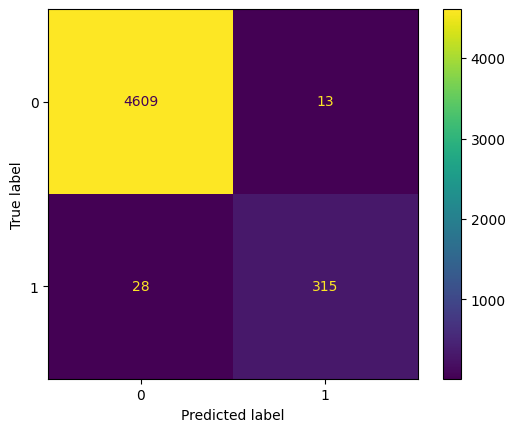

In [ ]:
# Testing Confusion Matrix
cm = confusion_matrix(test_labels, preds_test, labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

In [ ]:
test_results = np.vstack((test_labels, preds_test)).T
test_results = pd.DataFrame(data= test_results, columns=['label', 'pred'])
df_test = pd.concat([test_features_id.reset_index(), test_results], axis=1)
df_test.shape

(4965, 61)

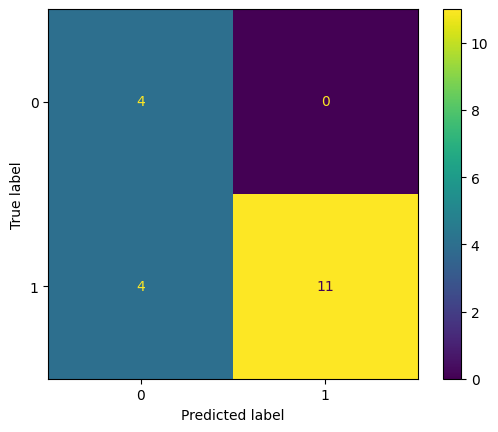

In [ ]:
df_test_N = df_test[df_test['#clean_country_name'] == 'Nigeria']
cm = confusion_matrix(df_test_N['label'], df_test_N['pred'], labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

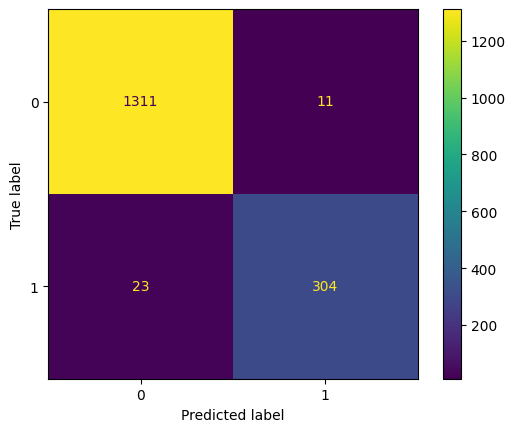

In [ ]:
df_test_N = df_test[df_test['#clean_country_name'] == 'Uganda']
cm = confusion_matrix(df_test_N['label'], df_test_N['pred'], labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

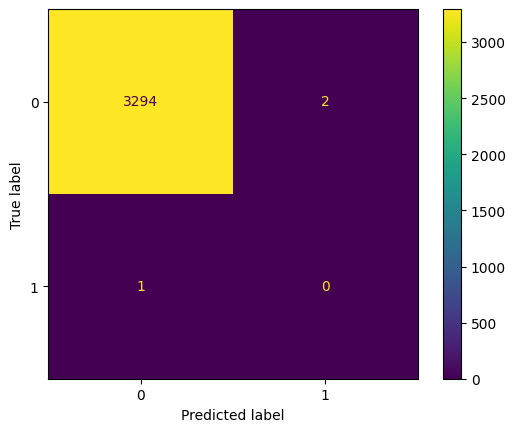

In [ ]:
df_test_N = df_test[df_test['#clean_country_name'] == 'Sierra Leone']
cm = confusion_matrix(df_test_N['label'], df_test_N['pred'], labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

In [ ]:
results = xgb_classifier.evals_result()

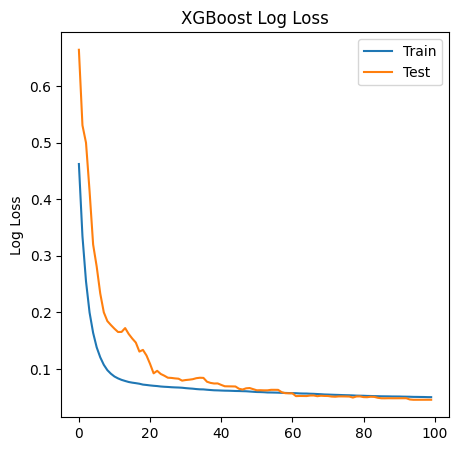

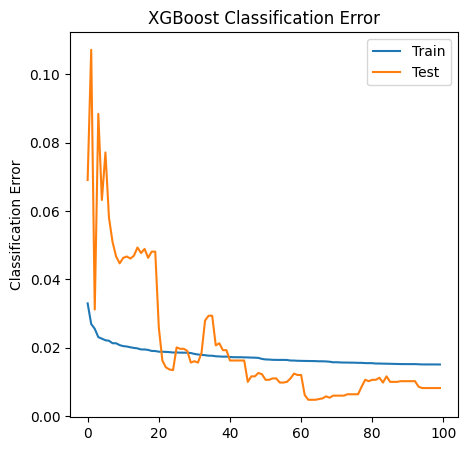

In [ ]:
from xgboost.plotting import plot_tree
# plot log loss
x_axis = range(0, 100)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

Features Importance

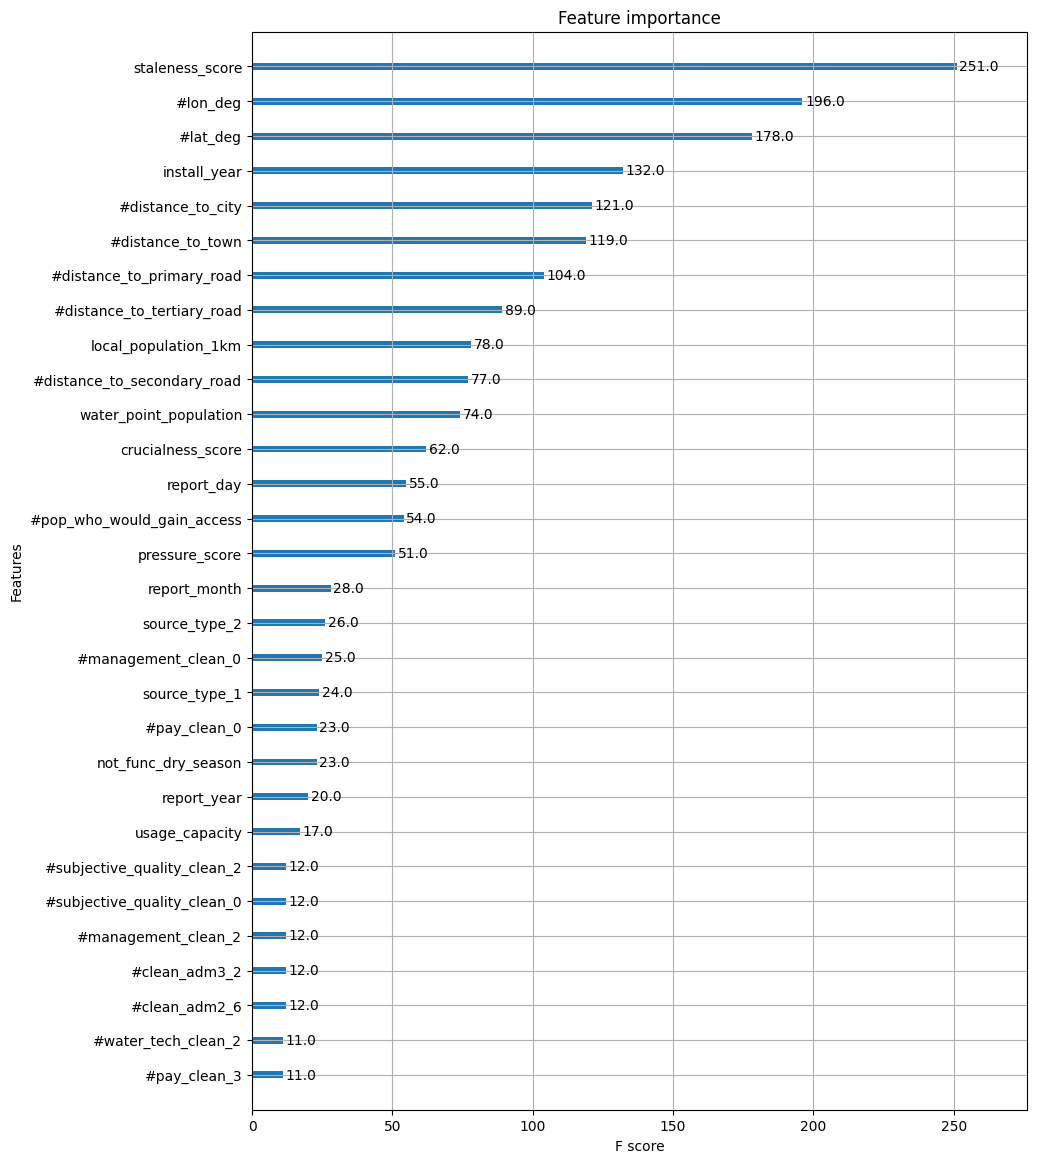

In [ ]:
# Review the important features
def plot_features(booster, figsize, max_num_features=20):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax, max_num_features=max_num_features)
plot_features(xgb_classifier, (10,14))
plt.show()

## VII. Baseline Model III (XGBoost): wpdx+sec_data
This second baseline will serve as the main baseline in developing our final model. It will be an XGBoost model with the default hyperparameters **WITH** the secondary data, and no stratification in the random sampling.

### A. Train, Test

In [ ]:
xgb_classifier = xgb.XGBClassifier(max_depth = 5)

eval_set = [(train_features, train_labels), (test_features, test_labels)]

xgb_classifier.fit(train_features,
                   train_labels,
                   eval_metric=["error", "logloss"],
                   eval_set=eval_set,
                   verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# Predict the labels of the train set
preds_train = xgb_classifier.predict(train_features)
preds_prob_train = xgb_classifier.predict_proba(train_features)[:,1]

# Predict the labels of the test set
preds_test = xgb_classifier.predict(test_features)
preds_prob_test = xgb_classifier.predict_proba(test_features)[:,1]

### B. Evaluation

In [ ]:
# Get training metrics
accuracy_train = accuracy_score(train_labels, preds_train)
precision_result = precision_score(train_labels, preds_train)
recall_result = recall_score(train_labels, preds_train)
f1_score_result = f1_score(train_labels, preds_train)
mcc_result = matthews_corrcoef(train_labels, preds_train)
auc_roc_result = roc_auc_score(train_labels, xgb_classifier.predict_proba(train_features)[:,1])

print('TRAINING METRICS')
print(f'train accuracy: {accuracy_train: .2%}')
print(f"Precision: {precision_result: .2%}")
print(f"Recall: {recall_result: .2%}")
print(f"F-1 Score: {f1_score_result: .2%}")
print(f"Matthews correlation coefficient: {mcc_result: .2%}")
print(f"AUC/ROC: {auc_roc_result: .2%}")

print()
# Get testing metrics
accuracy_test = accuracy_score(test_labels, preds_test)
precision_result = precision_score(test_labels, preds_test)
recall_result = recall_score(test_labels, preds_test)
f1_score_result = f1_score(test_labels, preds_test)
mcc_result = matthews_corrcoef(test_labels, preds_test)
auc_roc_result = roc_auc_score(test_labels, xgb_classifier.predict_proba(test_features)[:,1])

print('TESTING METRICS')
print(f'test accuracy: {accuracy_test: .2%}')
print(f"Precision: {precision_result: .2%}")
print(f"Recall: {recall_result: .2%}")
print(f"F-1 Score: {f1_score_result: .2%}")
print(f"Matthews correlation coefficient: {mcc_result: .2%}")
print(f"AUC/ROC: {auc_roc_result: .2%}")

TRAINING METRICS
train accuracy:  98.49%
Precision:  97.80%
Recall:  99.68%
F-1 Score:  98.73%
Matthews correlation coefficient:  96.89%
AUC/ROC:  99.72%

TESTING METRICS
test accuracy:  97.91%
Precision:  77.86%
Recall:  97.38%
F-1 Score:  86.53%
Matthews correlation coefficient:  86.04%
AUC/ROC:  99.77%


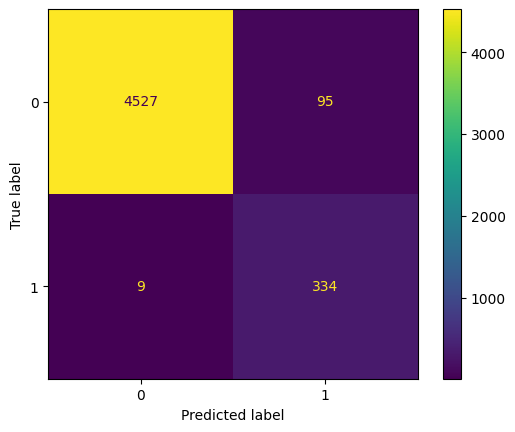

In [ ]:
# Testing Confusion Matrix
cm = confusion_matrix(test_labels, preds_test, labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

In [ ]:
test_results = np.vstack((test_labels, preds_test)).T
test_results = pd.DataFrame(data= test_results, columns=['label', 'pred'])
df_test = pd.concat([test_features_id.reset_index(), test_results], axis=1)
df_test.shape

(4965, 61)

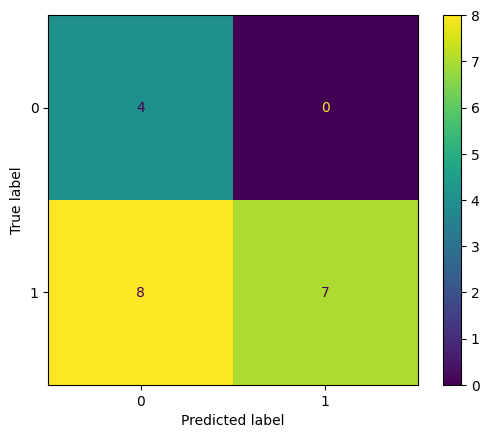

In [ ]:
df_test_N = df_test[df_test['#clean_country_name'] == 'Nigeria']
cm = confusion_matrix(df_test_N['label'], df_test_N['pred'], labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

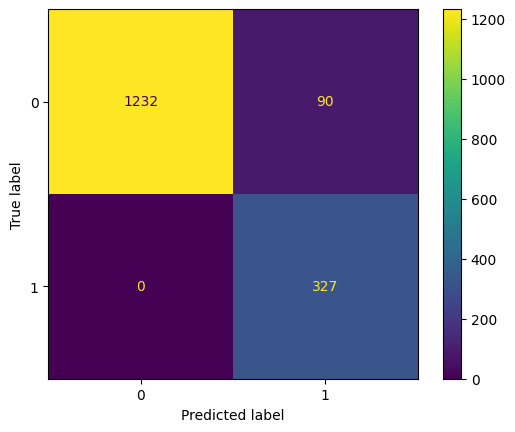

In [ ]:
df_test_N = df_test[df_test['#clean_country_name'] == 'Uganda']
cm = confusion_matrix(df_test_N['label'], df_test_N['pred'], labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

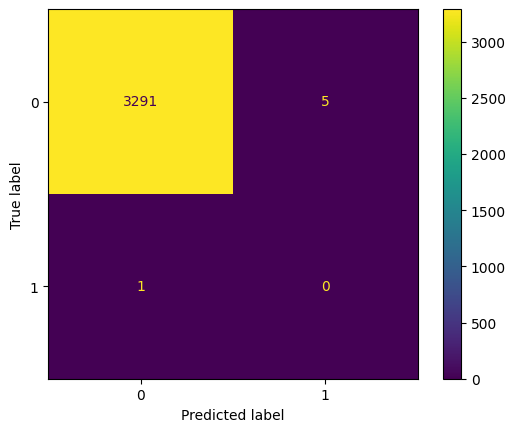

In [ ]:
df_test_N = df_test[df_test['#clean_country_name'] == 'Sierra Leone']
cm = confusion_matrix(df_test_N['label'], df_test_N['pred'], labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

In [ ]:
results = xgb_classifier.evals_result()

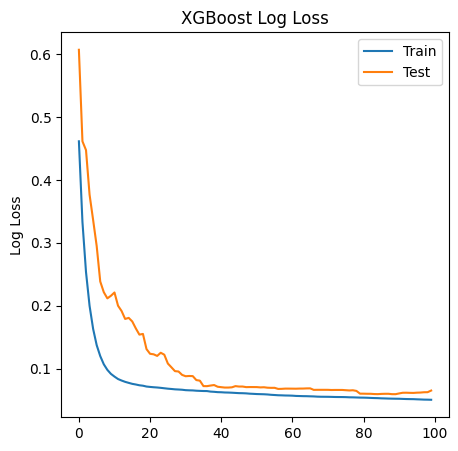

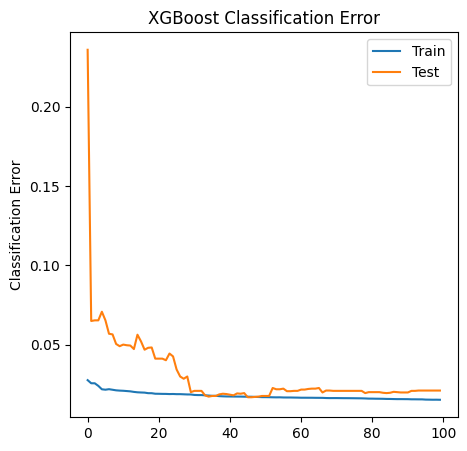

In [ ]:
from xgboost.plotting import plot_tree
# plot log loss
x_axis = range(0, 100)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

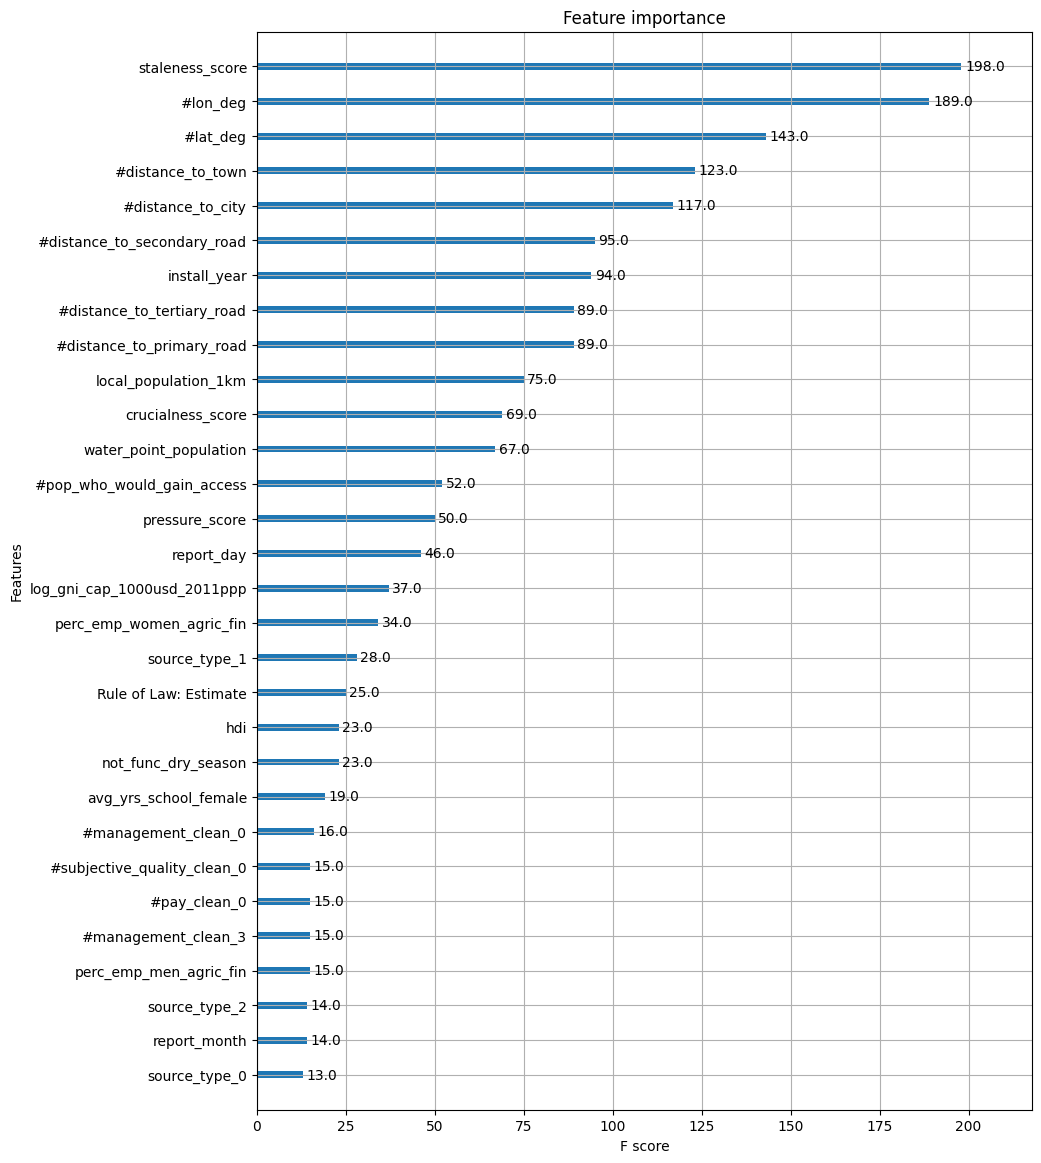

In [ ]:
# Review the important features
def plot_features(booster, figsize, max_num_features=30):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax, max_num_features=max_num_features)
plot_features(xgb_classifier, (10,14))
plt.show()

## VIII. Baseline Model IV (Decision Tree): wpdx+sec_data
This third baseline will serve as a comparison to show other modeling techniques against our main baseline. It will be an Random Forest model with the default hyperparameters **WITH** the secondary data, and no stratification in the random sampling.

### Impute NA values

In [ ]:
print("FEATURES BEFORE DROPPING NA VALUES")
print('Train features shape:', train_features.shape)
print('Train labels shape:', train_labels.shape)
print()
print()
print('Test features shape:', test_features.shape)
print('Test labels shape:', test_labels.shape)

FEATURES BEFORE DROPPING NA VALUES
Train features shape: (229230, 139)
Train labels shape: (229230,)


Test features shape: (4965, 139)
Test labels shape: (4965,)


In [ ]:
# Impute NA Values in DF
imp = SimpleImputer(missing_values= np.nan, strategy='mean')

In [ ]:
# Perform data split for both with and w/o secondary data
#cols_drop2 = ['report_date', 'row_id', '#wpdx_id']
# Train: 2005-2020
train_features_id = df[df['report_year'] < 2020]
train_features = df[df['report_year'] < 2020].drop(columns=cols_drop2)
train_features_wpdx = train_features.drop(columns = secondary_cols_drop)
train_labels = df[df['report_year'] < 2020]['status_fin']

# Test: 2021
test_features_id = df[(df['report_year'] >= 2020)]
test_features = df[(df['report_year'] >= 2020)].drop(columns=cols_drop2)
test_features_wpdx = test_features.drop(columns = secondary_cols_drop)
test_labels = df[(df['report_year'] >= 2020)]['status_fin']

# Binary Encoding
cat_cols = list(train_features.select_dtypes(exclude=('int64', 'float64')).columns)
cat_cols_wpdx = list(train_features_wpdx.select_dtypes(exclude=('int64', 'float64')).columns)
binary_encoder = ce.BinaryEncoder(cols = cat_cols, return_df = True)
binary_encoder_wpdx = ce.BinaryEncoder(cols = cat_cols_wpdx, return_df = True)

# Split to categorical features & rejoin with rest of dataset
train_features_cat = train_features.select_dtypes(exclude=('int64', 'float64'))
train_features_cat = binary_encoder.fit_transform(train_features_cat)
train_features = pd.concat([train_features.select_dtypes(exclude=('object', 'bool', 'datetime')), train_features_cat], axis=1)

train_features_cat_wpdx = train_features_wpdx.select_dtypes(exclude=('int64', 'float64'))
train_features_cat_wpdx = binary_encoder_wpdx.fit_transform(train_features_cat_wpdx)
train_features_wpdx = pd.concat([train_features_wpdx.select_dtypes(exclude=('object', 'bool', 'datetime')), train_features_cat_wpdx], axis=1)

test_features_cat = test_features.select_dtypes(exclude=('int64', 'float64'))
test_features_cat = binary_encoder.transform(test_features_cat)
test_features = pd.concat([test_features.select_dtypes(exclude=('object', 'bool', 'datetime')), test_features_cat], axis=1)

test_features_cat_wpdx = test_features_wpdx.select_dtypes(exclude=('int64', 'float64'))
test_features_cat_wpdx = binary_encoder_wpdx.transform(test_features_cat_wpdx)
test_features_wpdx = pd.concat([test_features_wpdx.select_dtypes(exclude=('object', 'bool', 'datetime')), test_features_cat_wpdx], axis=1)

# Perform data split for both with and w/o secondary data

train_features = imp.fit_transform(train_features)
test_features = imp.fit_transform(test_features)

In [ ]:
# train_labels = train_features.dropna(axis=0)['status_fin']
# test_labels = test_features.dropna(axis=0)['status_fin']
# train_features = train_features.dropna(axis=0).drop(columns=['status_fin'])
# test_features = test_features.dropna(axis=0).drop(columns=['status_fin'])

In [ ]:
# l=[]
# for i in test_features.columns:
#   if i not in test_features_drop.columns:
#     l.append(i)
# l

[]

In [ ]:
#test_features = pd.concat([test_features_drop, test_features[l]], axis=1)

In [ ]:
print("FEATURES AFTER DROPPING NA VALUES")
print('Train features shape:', train_features.shape)
print('Train labels shape:', train_labels.shape)
print()
print()
print('Test features shape:', test_features.shape)
print('Test labels shape:', test_labels.shape)

FEATURES AFTER DROPPING NA VALUES
Train features shape: (226131, 139)
Train labels shape: (226131,)


Test features shape: (8064, 139)
Test labels shape: (8064,)


### A. Train, Test

In [ ]:
# creating a DT classifier
clf = DecisionTreeClassifier(random_state=0)
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(train_features, train_labels)
# performing predictions on the test dataset
y_pred = clf.predict(test_features)

In [ ]:
# Predict the labels of the train set
preds_train = clf.predict(train_features)
preds_prob_train = clf.predict_proba(train_features)[:,1]

# Predict the labels of the test set
preds_test = clf.predict(test_features)
preds_prob_test = clf.predict_proba(test_features)[:,1]

### B. Evaluation

In [ ]:
# Get training metrics
accuracy_train = accuracy_score(train_labels, preds_train)
precision_result = precision_score(train_labels, preds_train)
recall_result = recall_score(train_labels, preds_train)
f1_score_result = f1_score(train_labels, preds_train)
mcc_result = matthews_corrcoef(train_labels, preds_train)
auc_roc_result = roc_auc_score(train_labels, clf.predict_proba(train_features)[:,1])

print('TRAINING METRICS')
print(f'train accuracy: {accuracy_train: .2%}')
print(f"Precision: {precision_result: .2%}")
print(f"Recall: {recall_result: .2%}")
print(f"F-1 Score: {f1_score_result: .2%}")
print(f"Matthews correlation coefficient: {mcc_result: .2%}")
print(f"AUC/ROC: {auc_roc_result: .2%}")

print()
# Get testing metrics
accuracy_test = accuracy_score(test_labels, preds_test)
precision_result = precision_score(test_labels, preds_test)
recall_result = recall_score(test_labels, preds_test)
f1_score_result = f1_score(test_labels, preds_test)
mcc_result = matthews_corrcoef(test_labels, preds_test)
#auc_roc_result = roc_auc_score(test_labels, clf.predict_proba(test_features)[:,1])

print('TESTING METRICS')
print(f'test accuracy: {accuracy_test: .2%}')
print(f"Precision: {precision_result: .2%}")
print(f"Recall: {recall_result: .2%}")
print(f"F-1 Score: {f1_score_result: .2%}")
print(f"Matthews correlation coefficient: {mcc_result: .2%}")
print(f"AUC/ROC: {auc_roc_result: .2%}")

TRAINING METRICS
train accuracy:  100.00%
Precision:  100.00%
Recall:  100.00%
F-1 Score:  100.00%
Matthews correlation coefficient:  100.00%
AUC/ROC:  100.00%

TESTING METRICS
test accuracy:  74.42%
Precision:  47.73%
Recall:  1.02%
F-1 Score:  2.00%
Matthews correlation coefficient:  3.76%
AUC/ROC:  100.00%


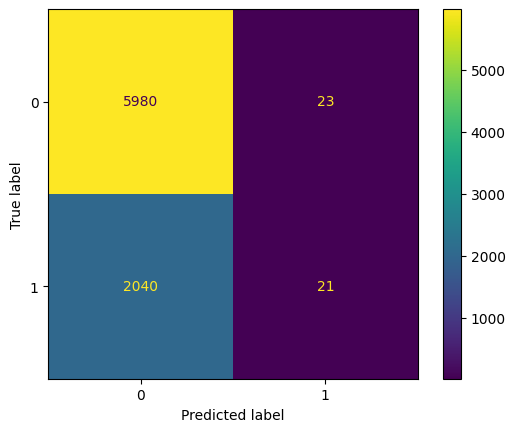

In [ ]:
# Testing Confusion Matrix
cm = confusion_matrix(test_labels, preds_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
test_results = np.vstack((test_labels, preds_test)).T
test_results = pd.DataFrame(data= test_results, columns=['label', 'pred'])
df_test = pd.concat([test_features_id.reset_index(), test_results], axis=1)
df_test.shape

(8064, 61)

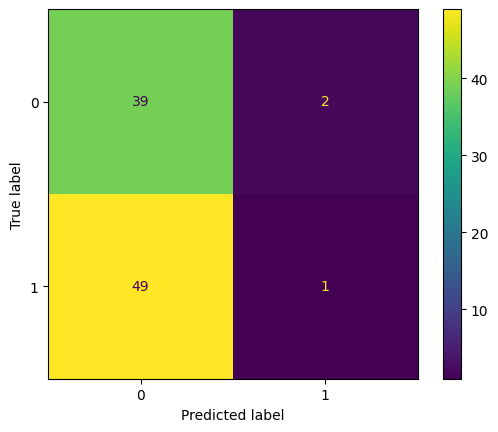

In [ ]:
df_test_N = df_test[df_test['#clean_country_name'] == 'Nigeria']
cm = confusion_matrix(df_test_N['label'], df_test_N['pred'], labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

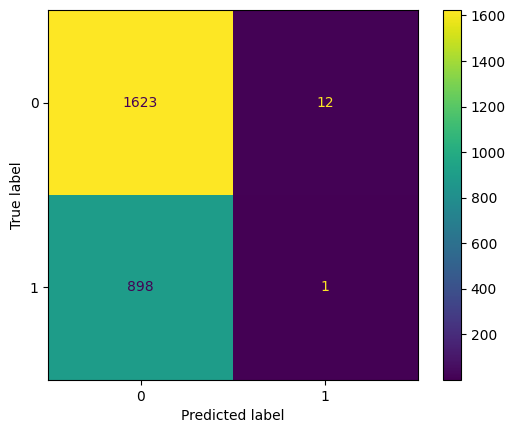

In [ ]:
df_test_N = df_test[df_test['#clean_country_name'] == 'Uganda']
cm = confusion_matrix(df_test_N['label'], df_test_N['pred'], labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

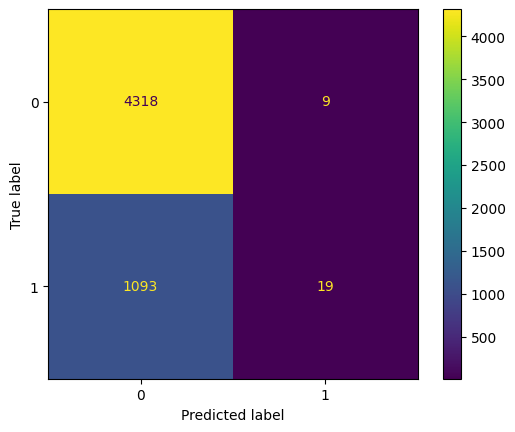

In [ ]:
df_test_N = df_test[df_test['#clean_country_name'] == 'Sierra Leone']
cm = confusion_matrix(df_test_N['label'], df_test_N['pred'], labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
results = clf.
results

array([1.62471357e-02, 3.88336408e-02, 5.42314388e-03, 5.77863998e-03,
       2.09057881e-03, 1.93774376e-03, 4.77038063e-01, 2.69352644e-03,
       1.84014761e-03, 9.63123824e-04, 4.88708377e-03, 4.81500015e-03,
       4.86155192e-03, 3.67467673e-02, 3.30875516e-04, 2.54667361e-03,
       2.17976932e-01, 1.20205081e-02, 5.55895545e-03, 1.52331430e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.13988580e-06,
       2.42733601e-05, 0.00000000e+00, 1.72642287e-05, 3.13367513e-05,
       2.79378019e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.39793775e-04, 7.78778641e-02, 5.04087921e-03, 1.56272698e-04,
       2.93685442e-04, 1.06679695e-03, 3.54630849e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.77258391e-05,
       7.92123436e-06, 2.37399631e-05, 3.48458146e-05, 4.34208580e-05,
       7.56339689e-05, 9.31565283e-05, 2.68545558e-04, 1.04359264e-04,
       3.63661564e-04, 2.46595151e-04, 1.73324353e-03, 1.24265351e-04,
      

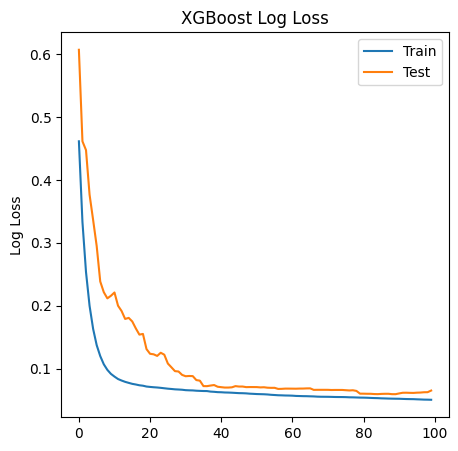

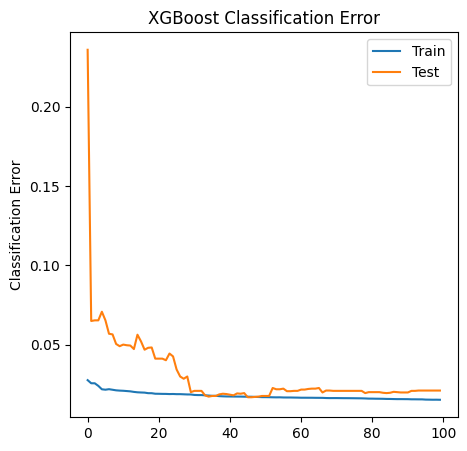

In [ ]:
from xgboost.plotting import plot_tree
# plot log loss
x_axis = range(0, 100)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

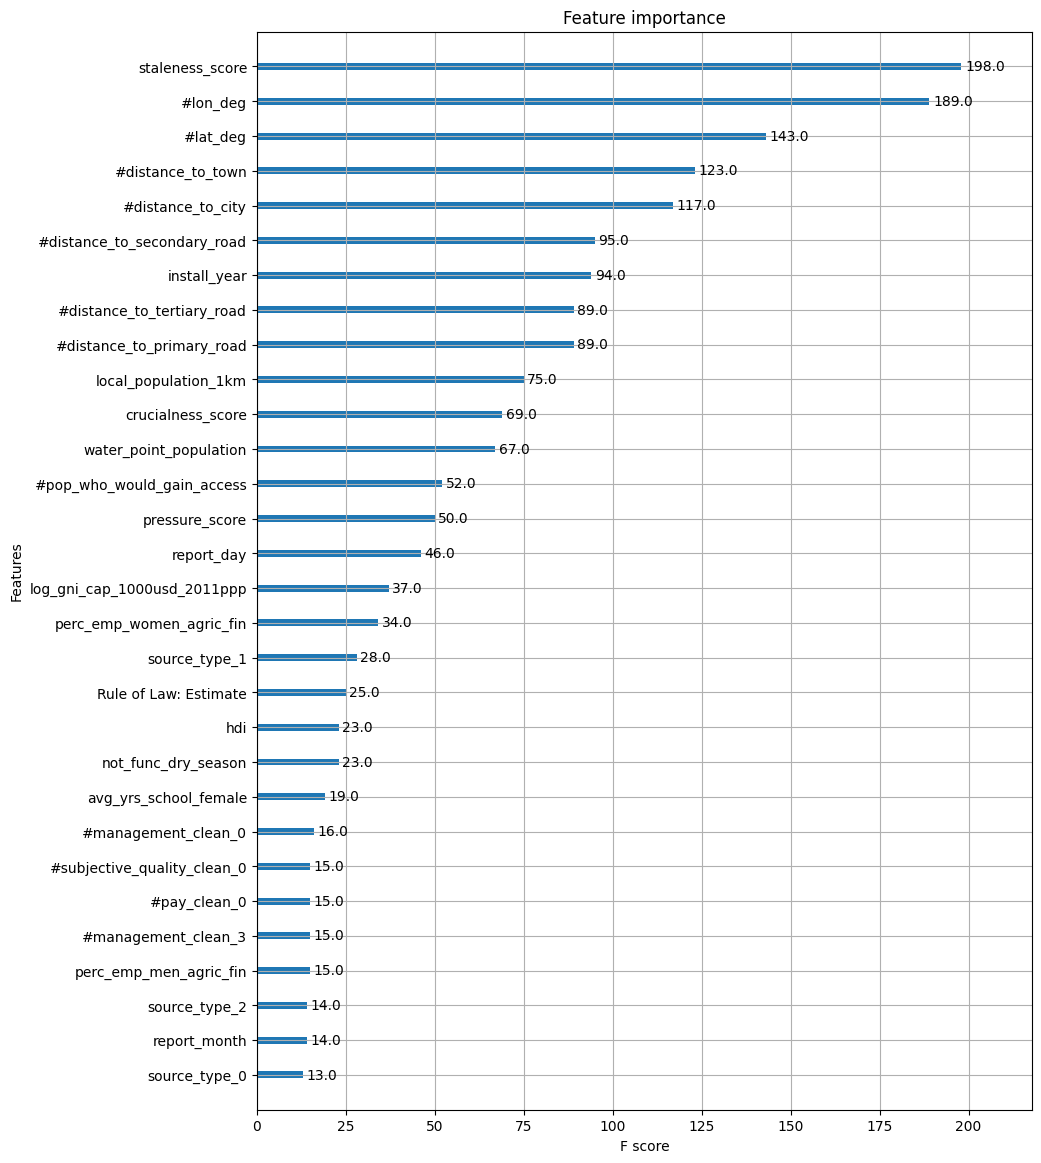

In [ ]:
# Review the important features
def plot_features(booster, figsize, max_num_features=30):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax, max_num_features=max_num_features)
plot_features(xgb_classifier, (10,14))
plt.show()